In [1]:
IMAGE_SIZE = 512
DEVICE = "cuda:0"
MODEL_PATH = "experiments/20250115_232801/model.pt"
IMAGE_FILE = "data/testing_images/vid_5_440.jpg"

# PyTorch

In [2]:
from PIL import Image
import torch
from model.detection_model import DetectionModel
from torchvision.transforms.functional import pil_to_tensor

model = DetectionModel(
    backbone="vgg11_bn",
    neck="yolov7",
    act="ReLU",
    max_height=0.1,
    max_width=0.1,
    alpha=2.0,
    beta=-0.5,
    gamma=2.0,
).eval().to(DEVICE)
model.load_state_dict(
    torch.load(MODEL_PATH, weights_only=True, map_location="cpu")
)

pil_image = Image.open(IMAGE_FILE)
image = pil_image.resize((IMAGE_SIZE, IMAGE_SIZE), resample=Image.BILINEAR)
image = pil_to_tensor(image)[None] / 255
image = image.to(DEVICE)

with torch.inference_mode(), torch.amp.autocast("cuda"):
    out = model(image)

out = model.postprocess(out, conf_thres=0.1, nms_thres=0.3, max_detections=5000)[0]
out = out.tolist()
print(f"Number of objects found: {len(out)}")

Number of objects found: 1


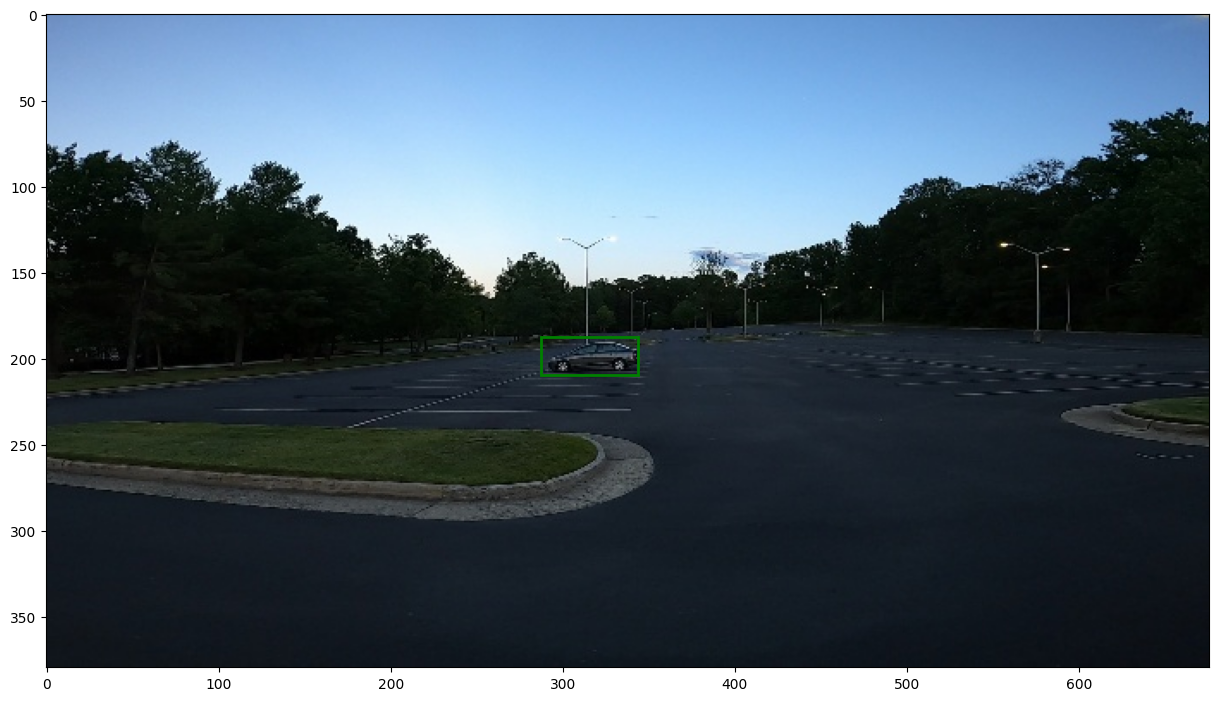

In [3]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def show_prediction(orig_image, pred):
    plt.figure(figsize=(15, 10))
    
    plt.imshow(orig_image)
    ax = plt.gca()
    for x0, y0, x1, y1, conf in pred:
        x0 = pil_image.width * (x0 / IMAGE_SIZE)
        y0 = pil_image.height * (y0 / IMAGE_SIZE)
        x1 = pil_image.width * (x1 / IMAGE_SIZE)
        y1 = pil_image.height * (y1 / IMAGE_SIZE)
        rect = Rectangle(
            (x0, y0), x1 - x0, y1 - y0, linewidth=2, edgecolor="green", facecolor="none"
        )
        ax.add_patch(rect)
    
    plt.show()

show_prediction(pil_image, out)

# ONNX

In [5]:
import onnx
import torch

def export_to_onnx(model, save_path="detection_model.onnx"):
    dummy_input = torch.randn(1, 3, IMAGE_SIZE, IMAGE_SIZE, device=DEVICE)

    torch.onnx.export(
        model,
        dummy_input,
        save_path,
        export_params=True,
        opset_version=13,
        do_constant_folding=True,
        input_names=["input"],
        output_names=["detections"],
        dynamic_axes={
            "input": {0: "batch_size"},
            "detections": {0: "batch_size", 1: "num_detections"},
        },
        verbose=True,
    )

    onnx_model = onnx.load(save_path)
    onnx.checker.check_model(onnx_model)
    print(f"Model successfully exported to {save_path}")

export_to_onnx(model)

Model successfully exported to detection_model.onnx


In [6]:
import numpy as np
import onnxruntime as ort


def postprocess(preds, conf_thres=0.3, nms_thres=0.3):
    # Get predictions above confidence threshold
    preds = preds[0]  # First image in batch
    mask = preds[:, 4] >= conf_thres
    preds = preds[mask]

    if len(preds) == 0:
        return []

    # Convert cxcywh to xyxy
    boxes = preds[:, :4]
    cx, cy, w, h = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    boxes = np.stack(
        [
            cx - w / 2,  # x1
            cy - h / 2,  # y1
            cx + w / 2,  # x2
            cy + h / 2,  # y2
        ],
        axis=1,
    )

    # Simple NMS
    scores = preds[:, 4]
    indices = scores.argsort()[::-1]
    keep = []

    while indices.size > 0:
        i = indices[0]
        keep.append(i)

        if indices.size == 1:
            break

        # Calculate IoU with rest of boxes
        box1 = boxes[i]
        box2 = boxes[indices[1:]]

        x1 = np.maximum(box1[0], box2[:, 0])
        y1 = np.maximum(box1[1], box2[:, 1])
        x2 = np.minimum(box1[2], box2[:, 2])
        y2 = np.minimum(box1[3], box2[:, 3])

        w = np.maximum(0, x2 - x1)
        h = np.maximum(0, y2 - y1)
        intersection = w * h

        box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
        box2_area = (box2[:, 2] - box2[:, 0]) * (box2[:, 3] - box2[:, 1])
        union = box1_area + box2_area - intersection

        iou = intersection / union
        indices = indices[1:][iou <= nms_thres]

    return np.concatenate([boxes[keep], preds[keep, 4:5]], axis=1)

def load_image(image_path):
    pil_image = Image.open(image_path)
    image = pil_image.resize((IMAGE_SIZE, IMAGE_SIZE), resample=Image.BILINEAR)
    image = np.asarray(image).astype(np.float32) / 255.0
    image = np.transpose(image, (2, 0, 1))
    image = np.expand_dims(image, axis=0)
    return pil_image, image

pil_image, image = load_image(IMAGE_FILE)
session = ort.InferenceSession(
    "detection_model.onnx", providers=["CPUExecutionProvider"] # or "CUDAExecutionProvider"
)
outputs = session.run(None, {"input": image})[0]
out = postprocess(outputs)

2025-01-15 23:58:18.272540817 [E:onnxruntime:Default, env.cc:234 ThreadMain] pthread_setaffinity_np failed for thread: 503, index: 2, mask: {49, }, error code: 22 error msg: Invalid argument. Specify the number of threads explicitly so the affinity is not set.
2025-01-15 23:58:18.272588036 [E:onnxruntime:Default, env.cc:234 ThreadMain] pthread_setaffinity_np failed for thread: 502, index: 1, mask: {1, }, error code: 22 error msg: Invalid argument. Specify the number of threads explicitly so the affinity is not set.
2025-01-15 23:58:18.272626595 [E:onnxruntime:Default, env.cc:234 ThreadMain] pthread_setaffinity_np failed for thread: 501, index: 0, mask: {48, }, error code: 22 error msg: Invalid argument. Specify the number of threads explicitly so the affinity is not set.
2025-01-15 23:58:18.275583363 [E:onnxruntime:Default, env.cc:234 ThreadMain] pthread_setaffinity_np failed for thread: 504, index: 3, mask: {2, }, error code: 22 error msg: Invalid argument. Specify the number of threa

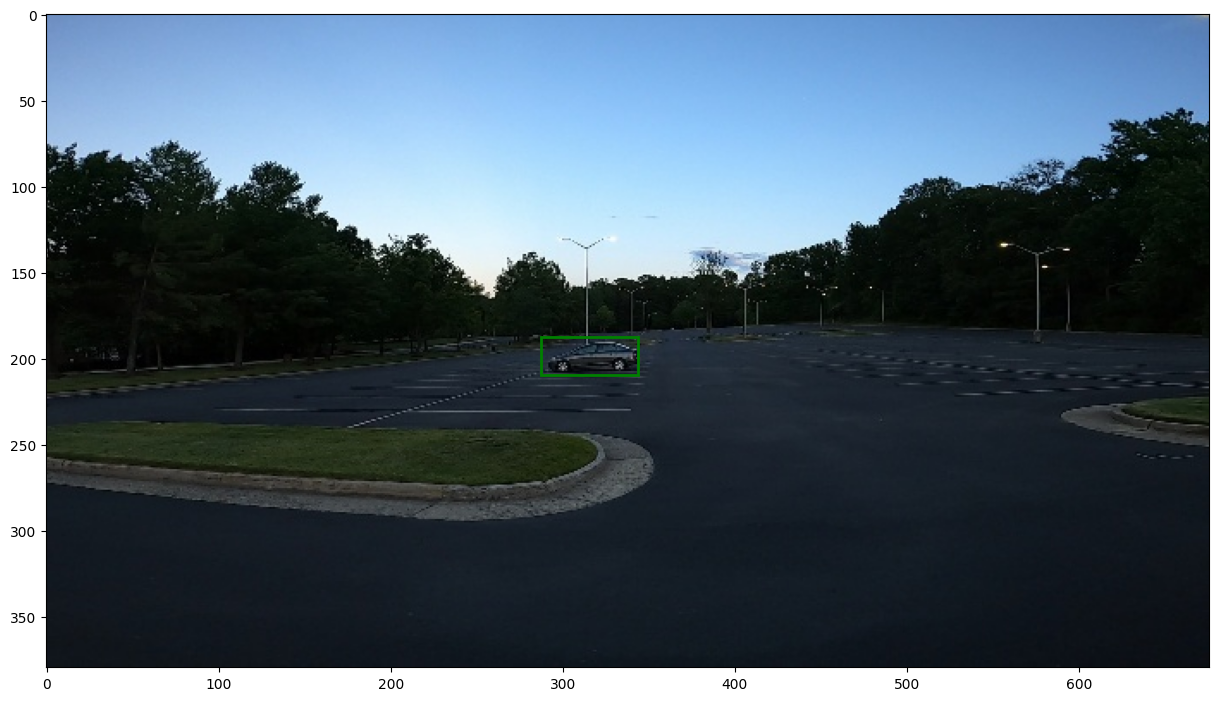

In [7]:
show_prediction(pil_image, out)